# Facial recognition benchmark

Bencharks are available after the image loading section.

There are three options:

1. cnvW1A1
2. lfcW1A1
3. lfcW1A2

# Constants, imports and functions

Declare constants.

In [1]:
# Storage configuration
DATA_PATH = "data"
PYTHON_PATH = "/usr/local/lib/python3.6"
PYTHON_PKG_PATH = f"{PYTHON_PATH}/dist-packages"
BNN_PATH = f"{PYTHON_PKG_PATH}/bnn"
YALE_PATH = f"{DATA_PATH}/img/yale_faces"
TMP_FILE = "/dev/shm/tmp_file"

BENCH_PATH =  f"{DATA_PATH}/benchmarks"
BENCH_FILE = f"{BENCH_PATH}/facial_recognition_bench.json"

ITERATIONS = 100

# Classifier configuration
BNN_CLASSIFIER = "facial_recognition"

# Image configuration
RESOLUTION = 28

Import the BNN library and other necessary modules.

In [2]:
import array
import bnn
from contextlib import redirect_stdout
import cv2
import numpy as np
from os import devnull, listdir, makedirs
import json
from PIL import Image
from pynq import Xlnk
from random import randint
import re
import sys
from time import time

Define functions to pre-process images before classifying them.

In [3]:
def format_lfc_img(img):
    img = np.array(img)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (RESOLUTION, RESOLUTION), fx = 0.1, fy = 0.1)
    face_array = array.array('B')  

    for x in range(RESOLUTION):  
        for y in range(RESOLUTION):  
            face_array.append(img[y, x])

    # configure header of the MNIST format file         
    hexval = "{0:#0{1}x}".format(1,6)  
    header = array.array('B')  
    header.extend([0, 0, 8, 1, 0, 0])  
    header.append(int('0x' + hexval[2:][:2], 16))  
    header.append(int('0x' + hexval[2:][2:], 16))  
    header.extend([0, 0, 0, RESOLUTION, 0, 0, 0, RESOLUTION])  
    header[3] = 3 # Changing MSB for image data (0x00000803)  
    face_array = header + face_array  
    with open(TMP_FILE, "wb") as f:
        # the classifier will read it the file, which is in memory
        face_array.tofile(f)
    return img

def format_cnv_img(img):
    _img = Image.fromarray(np.array(img))
    _img.thumbnail((64, 64), Image.ANTIALIAS)
    return _img

Create required directories

In [4]:
try:
    makedirs(BENCH_PATH)
except FileExistsError:
    pass

# Image loading

Select a random image from the yale faces.

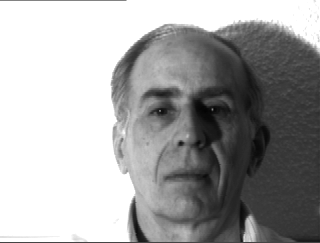

In [5]:
yale_imgs = listdir(YALE_PATH)
img_path = f"{YALE_PATH}/{yale_imgs[randint(0, len(yale_imgs)-1)]}"
img = Image.open(img_path)
img

# Benchmarks

### LFCW1A1

HW

In [6]:
_img = Image.fromarray(format_lfc_img(img))
topology = bnn.NETWORK_LFCW1A1
start = time()
hw_classifier = bnn.LfcClassifier(topology, BNN_CLASSIFIER, bnn.RUNTIME_HW)
end = time()
micros = int((end - start) * 1e6)
print(f"Classifier loaded in {micros} microseconds")

lfcw1a1_hw_times = []
for i in range(ITERATIONS):
    print(f"\rIteration {i+1}", end="")
    # Redirect the prints of the classification  function
    with open(devnull, "w") as f, redirect_stdout(f):
        start = time()
        hw_classifier.classify_mnist(TMP_FILE)
        end = time()
        micros = int((end - start) * 1e6)
        lfcw1a1_hw_times.append(micros)
print()
xlnk = Xlnk()
xlnk.xlnk_reset()
print("LFCW1A1 HW times in microseconds:\n  MAX: {}\n  AVG: {}\n  MIN: {}".format(
        max(lfcw1a1_hw_times),
        sum(lfcw1a1_hw_times)//ITERATIONS,
        min(lfcw1a1_hw_times)
    ))

Classifier loaded in 613112 microseconds
Iteration 100
LFCW1A1 HW times in microseconds:
  MAX: 7676
  AVG: 995
  MIN: 866


SW

In [7]:
_img = Image.fromarray(format_lfc_img(img))
topology = bnn.NETWORK_LFCW1A1
start = time()
sw_classifier = bnn.LfcClassifier(topology, BNN_CLASSIFIER, bnn.RUNTIME_SW)
end = time()
micros = int((end - start) * 1e6)
print(f"Classifier loaded in {micros} microseconds")

lfcw1a1_sw_times = []
for i in range(ITERATIONS):
    print(f"\rIteration {i+1}", end="")
    with open(devnull, "w") as f, redirect_stdout(f):
        start = time()
        sw_classifier.classify_mnist(TMP_FILE)
        end = time()
        micros = int((end - start) * 1e6)
        lfcw1a1_sw_times.append(micros)
print()
xlnk = Xlnk()
xlnk.xlnk_reset()
print("LFCW1A1 SW times in microseconds:\n  MAX: {}\n  AVG: {}\n  MIN: {}".format(
        max(lfcw1a1_sw_times),
        sum(lfcw1a1_sw_times)//ITERATIONS,
        min(lfcw1a1_sw_times)
    ))

Classifier loaded in 32323 microseconds
Iteration 100
LFCW1A1 SW times in microseconds:
  MAX: 398390
  AVG: 23494
  MIN: 19426


### LFCW1A2

HW

In [8]:
_img = Image.fromarray(format_lfc_img(img))
topology = bnn.NETWORK_LFCW1A2
start = time()
hw_classifier = bnn.LfcClassifier(topology, BNN_CLASSIFIER, bnn.RUNTIME_HW)
end = time()
micros = int((end - start) * 1e6)
print(f"Classifier loaded in {micros} microseconds")

lfcw1a2_hw_times = []
for i in range(ITERATIONS):
    print(f"\rIteration {i+1}", end="")
    with open(devnull, "w") as f, redirect_stdout(f):
        start = time()
        hw_classifier.classify_mnist(TMP_FILE)
        end = time()
        micros = int((end - start) * 1e6)
        lfcw1a2_hw_times.append(micros)
print()
xlnk = Xlnk()
xlnk.xlnk_reset()
print("LFCW1A2 HW times in microseconds:\n  MAX: {}\n  AVG: {}\n  MIN: {}".format(
        max(lfcw1a2_hw_times),
        sum(lfcw1a2_hw_times)//ITERATIONS,
        min(lfcw1a2_hw_times)
    ))

Classifier loaded in 603682 microseconds
Iteration 100
LFCW1A2 HW times in microseconds:
  MAX: 1464
  AVG: 925
  MIN: 878


SW

In [9]:
_img = Image.fromarray(format_lfc_img(img))
topology = bnn.NETWORK_LFCW1A2
start = time()
sw_classifier = bnn.LfcClassifier(topology, BNN_CLASSIFIER, bnn.RUNTIME_SW)
end = time()
micros = int((end - start) * 1e6)
print(f"Classifier loaded in {micros} microseconds")

lfcw1a2_sw_times = []
for i in range(ITERATIONS):
    print(f"\rIteration {i+1}", end="")
    with open(devnull, "w") as f, redirect_stdout(f):
        start = time()
        sw_classifier.classify_mnist(TMP_FILE)
        end = time()
        micros = int((end - start) * 1e6)
        lfcw1a2_sw_times.append(micros)
print()
xlnk = Xlnk()
xlnk.xlnk_reset()
print("LFCW1A2 SW times in microseconds:\n  MAX: {}\n  AVG: {}\n  MIN: {}".format(
        max(lfcw1a2_sw_times),
        sum(lfcw1a2_sw_times)//ITERATIONS,
        min(lfcw1a2_sw_times)
    ))

Classifier loaded in 32976 microseconds
Iteration 100
LFCW1A2 SW times in microseconds:
  MAX: 146041
  AVG: 131277
  MIN: 130826


### CNVW1A1

HW

In [10]:
_img = format_cnv_img(img)
start = time()
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, BNN_CLASSIFIER, bnn.RUNTIME_HW)
end = time()
micros = int((end - start) * 1e6)
print(f"Classifier loaded in {micros} microseconds")

cnvw1a1_hw_times = []
for i in range(ITERATIONS):
    print(f"\rIteration {i+1}", end="")
    with open(devnull, "w") as f, redirect_stdout(f):
        start = time()
        hw_classifier.classify_images([_img])[0]
        end = time()
        micros = int((end - start) * 1e6)
        cnvw1a1_hw_times.append(micros)
print()
xlnk = Xlnk()
xlnk.xlnk_reset()
print("LFCW1A1 HW times in microseconds:\n  MAX: {}\n  AVG: {}\n  MIN: {}".format(
        max(cnvw1a1_hw_times),
        sum(cnvw1a1_hw_times)//ITERATIONS,
        min(cnvw1a1_hw_times)
    ))

Classifier loaded in 1275916 microseconds
Iteration 100
LFCW1A1 HW times in microseconds:
  MAX: 161845
  AVG: 13446
  MIN: 11730


SW

In [11]:
_img = format_cnv_img(img)
start = time()
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, BNN_CLASSIFIER, bnn.RUNTIME_SW)
end = time()
micros = int((end - start) * 1e6)
print(f"Classifier loaded in {micros} microseconds")

cnvw1a1_sw_times = []
for i in range(ITERATIONS):
    print(f"\rIteration {i+1}", end="")
    with open(devnull, "w") as f, redirect_stdout(f):
        start = time()
        hw_classifier.classify_images([_img])[0]
        end = time()
        micros = int((end - start) * 1e6)
        cnvw1a1_sw_times.append(micros)
print()
xlnk = Xlnk()
xlnk.xlnk_reset()
print("LFCW1A1 SW times in microseconds:\n  MAX: {}\n  AVG: {}\n  MIN: {}".format(
        max(cnvw1a1_sw_times),
        sum(cnvw1a1_sw_times)//ITERATIONS,
        min(cnvw1a1_sw_times)
    ))

Classifier loaded in 1111572 microseconds
Iteration 100
LFCW1A1 SW times in microseconds:
  MAX: 930799
  AVG: 432284
  MIN: 420800


## Save results

In [12]:
results = {
    "lfcw1a1": {
        "hw": lfcw1a1_hw_times,
        "sw": lfcw1a1_sw_times
    },
    "lfcw1a2": {
        "hw": lfcw1a2_hw_times,
        "sw": lfcw1a2_sw_times
    },
    "cnvw1a1": {
        "hw": cnvw1a1_hw_times,
        "sw": cnvw1a1_sw_times
    }
}

with open(BENCH_FILE, 'w') as f:
    f.write(json.dumps(results))

## Comparisons

Load results

In [2]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

results = {}
with open(BENCH_FILE, 'r') as f:
    results = json.loads(f.read())

lfcw1a1_hw = results["lfcw1a1"]["hw"]
lfcw1a1_sw = results["lfcw1a1"]["sw"]
lfcw1a2_hw = results["lfcw1a2"]["hw"]
lfcw1a2_sw = results["lfcw1a2"]["sw"]
cnvw1a1_hw = results["cnvw1a1"]["hw"]
cnvw1a1_sw = results["cnvw1a1"]["sw"]

Compare them against each other

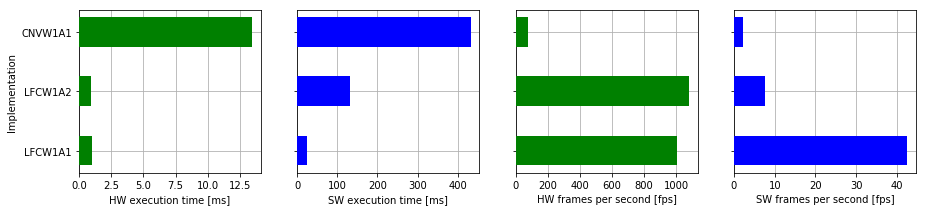

In [3]:
lfcw1a1_hw_avg = sum(lfcw1a1_hw)/ITERATIONS/1000
lfcw1a2_hw_avg = sum(lfcw1a2_hw)/ITERATIONS/1000
cnvw1a1_hw_avg = sum(cnvw1a1_hw)/ITERATIONS/1000
lfcw1a1_sw_avg = sum(lfcw1a1_sw)/ITERATIONS/1000
lfcw1a2_sw_avg = sum(lfcw1a2_sw)/ITERATIONS/1000
cnvw1a1_sw_avg = sum(cnvw1a1_sw)/ITERATIONS/1000

lfcw1a1_hw_fps = 1000/lfcw1a1_hw_avg
lfcw1a2_hw_fps = 1000/lfcw1a2_hw_avg
cnvw1a1_hw_fps = 1000/cnvw1a1_hw_avg
lfcw1a1_sw_fps = 1000/lfcw1a1_sw_avg
lfcw1a2_sw_fps = 1000/lfcw1a2_sw_avg
cnvw1a1_sw_fps = 1000/cnvw1a1_sw_avg

labels = ["LFCW1A1", "LFCW1A2", "CNVW1A1"]

fig, (a1, a2, a3, a4) = plt.subplots(1, 4, sharex="col", sharey="row", figsize=(15,3))
x_pos = np.arange(len(labels))

plt.yticks(x_pos, labels)
a1.invert_yaxis()
a1.set_xlabel("HW execution time [ms]")
a1.set_ylabel("Implementation")
a1.barh(x_pos, (lfcw1a1_hw_avg, lfcw1a2_hw_avg, cnvw1a1_hw_avg), height=0.5, color="g", zorder=3)
a1.grid(zorder=0)

a2.invert_yaxis()
a2.set_xlabel("SW execution time [ms]")
a2.barh(x_pos, (lfcw1a1_sw_avg, lfcw1a2_sw_avg, cnvw1a1_sw_avg), color="b", height=0.5, zorder=3)
a2.grid(zorder=0)

a3.invert_yaxis()
a3.set_xlabel("HW frames per second [fps]")
a3.barh(x_pos, (lfcw1a1_hw_fps, lfcw1a2_hw_fps, cnvw1a1_hw_fps), height=0.5, color="g", zorder=3)
a3.grid(zorder=0)

a4.invert_yaxis()
a4.set_xlabel("SW frames per second [fps]")
a4.barh(x_pos, (lfcw1a1_sw_fps, lfcw1a2_sw_fps, cnvw1a1_sw_fps), color="b", height=0.5, zorder=3)
a4.grid(zorder=0)

plt.show()

Compare the HW and SW implementations

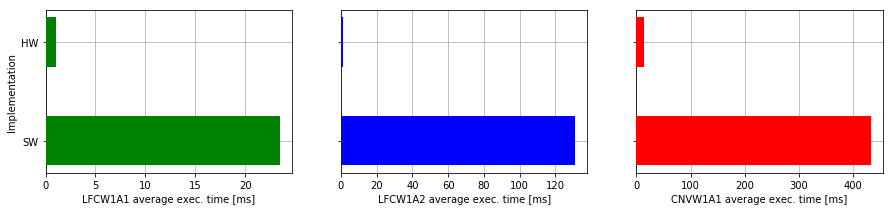

In [4]:
labels = ["HW", "SW"]

fig, (a1, a2, a3) = plt.subplots(1, 3, sharex="col", sharey="row", figsize=(15,3))
x_pos = np.arange(len(labels))

plt.yticks(x_pos, labels)
a1.invert_yaxis()
a1.set_xlabel("LFCW1A1 average exec. time [ms]")
a1.set_ylabel("Implementation")
a1.barh(x_pos, (lfcw1a1_hw_avg, lfcw1a1_sw_avg), height=0.5, color="g", zorder=3)
a1.grid(zorder=0)

a2.invert_yaxis()
a2.set_xlabel("LFCW1A2 average exec. time [ms]")
a2.barh(x_pos, (lfcw1a2_hw_avg, lfcw1a2_sw_avg), color="b", height=0.5, zorder=3)
a2.grid(zorder=0)

a3.invert_yaxis()
a3.set_xlabel("CNVW1A1 average exec. time [ms]")
a3.barh(x_pos, (cnvw1a1_hw_avg, cnvw1a1_sw_avg), color="r", height=0.5, zorder=3)
a3.grid(zorder=0)

plt.show()

#  